Dimer with Kanamori interaction
=======

We calculate the Green function of a dimer coupled with Kanamori interaction and a coupling to discrete bath states.

The non-interacting hamiltonian is most conveniently expressed using a matrix representation

$$
\hat{h} =
\begin{pmatrix}
\hat{h}_{0} & \hat{h}_{\rm coup} \\
\hat{h}_{\rm coup} & \hat{h}_{\rm bath}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
\epsilon_0 -\mu & -t \\
-t & \epsilon_1 -\mu
\end{pmatrix} & 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\\
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix} & 
\begin{pmatrix}
\epsilon_{0,{\rm bath}} & -t_{\rm bath} \\
-t_{\rm bath} & \epsilon_{1,{\rm bath}}
\end{pmatrix}
\end{pmatrix}
$$

The impurity interaction is of the Kanamori-type, and reads

$$h_{\rm int} = \sum_{i,j} U n_{\uparrow,i} n_{\downarrow,j} + \sum_{\sigma,i\neq j} U' n_{\sigma,i} n_{\sigma,j}
            - \sum_{i \neq j} J c^\dagger_{i \uparrow} c_{i \downarrow} c^\dagger_{j \downarrow} c_{j \uparrow}
            + \sum_{i \neq j} J c^\dagger_{i \uparrow} c^\dagger_{i \downarrow} c_{j \downarrow} c_{j \uparrow}$$
   
The parameters are defined below.

In [3]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from triqs.operators import c, c_dag, n
from triqs.operators.util import h_int_kanamori, U_matrix_kanamori
from itertools import product
from numpy import matrix, array, block, diag, eye
from numpy.linalg import inv

# ==== System Parameters ====
beta = 5.                       # Inverse temperature
mu = 0.0                        # Chemical potential
eps = array([0.0, 0.1])         # Impurity site energies
t = 0.2                         # Hopping between impurity sites

eps_bath = array([0.27, -0.4])  # Bath site energies
t_bath = 0.0                    # Hopping between bath sites

U = 1.                          # Density-density interaction
J = 0.2                         # Hunds coupling

block_names = ['up', 'dn']
n_orb = len(eps)
n_orb_bath = len(eps_bath)

# Non-interacting impurity hamiltonian in matrix representation
h_0_mat = diag(eps - mu) - matrix([[0, t],
                                   [t, 0]])

# Bath hamiltonian in matrix representation
h_bath_mat = diag(eps_bath) - matrix([[0, t_bath],
                                      [t_bath, 0]])

# Coupling matrix
V_mat = matrix([[1., 1.],
                [1., 1.]])

# ==== Local Hamiltonian ====
c_dag_vec = { s: matrix([[c_dag(s,o) for o in range(n_orb)]]) for s in block_names }
c_vec =     { s: matrix([[c(s,o)] for o in range(n_orb)]) for s in block_names }

h_0 = sum(c_dag_vec[s] * h_0_mat * c_vec[s] for s in block_names)[0,0]

Umat, Upmat = U_matrix_kanamori(n_orb, U_int=U, J_hund=J)
h_int = h_int_kanamori(block_names, range(n_orb), Umat, Upmat, J, off_diag=True)

h_imp = h_0 + h_int

# ==== Bath & Coupling hamiltonian ====
c_dag_bath_vec = { s: matrix([[c_dag(s, o) for o in range(n_orb, n_orb + n_orb_bath)]]) for s in block_names }
c_bath_vec =     { s: matrix([[c(s, o)] for o in range(n_orb, n_orb + n_orb_bath)]) for s in block_names }

h_bath = sum(c_dag_bath_vec[s] * h_bath_mat * c_bath_vec[s] for s in block_names)[0,0]
h_coup = sum(c_dag_vec[s] * V_mat * c_bath_vec[s] + c_dag_bath_vec[s] * V_mat * c_vec[s] for s in block_names)[0,0] # FIXME Adjoint

# ==== Total impurity hamiltonian ====
h_tot = h_imp + h_coup + h_bath

# ==== Green function structure ====
gf_struct = [ (s, n_orb) for s in block_names ]

# ==== Non-Interacting Impurity Green function  ====
n_iw = int(10 * beta)
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
G0_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
h_tot_mat = block([[h_0_mat, V_mat     ],
                   [V_mat.H, h_bath_mat]])
for bl, iw in product(block_names, iw_mesh):
    G0_iw[bl][iw] = inv(iw.value * eye(2*n_orb) - h_tot_mat)[:n_orb, :n_orb]

# ==== Hybridization Function ====
Delta = G0_iw.copy()
Delta['up'] << iOmega_n - h_0_mat - inverse(G0_iw['up'])
Delta['dn'] << iOmega_n - h_0_mat - inverse(G0_iw['dn'])


Greens Function G_dn with mesh Matsubara Freq Mesh of size 100, Domain: Matsubara domain with beta = 5, statistic = 1, positive_only : 0 and target_rank 2: 

Results
====

In [4]:
from triqs.plot.mpl_interface import oplot, plt
%matplotlib inline

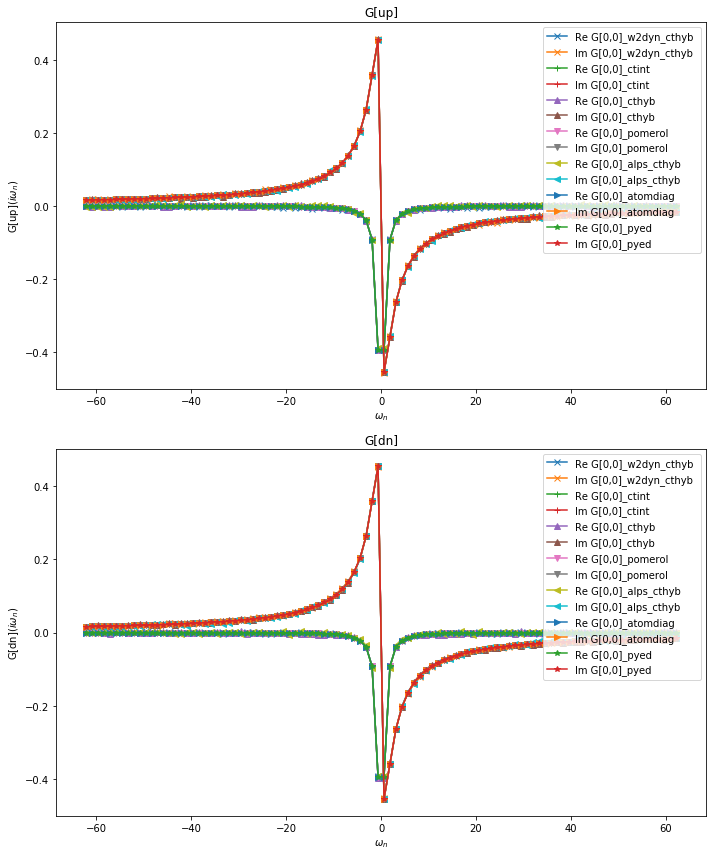

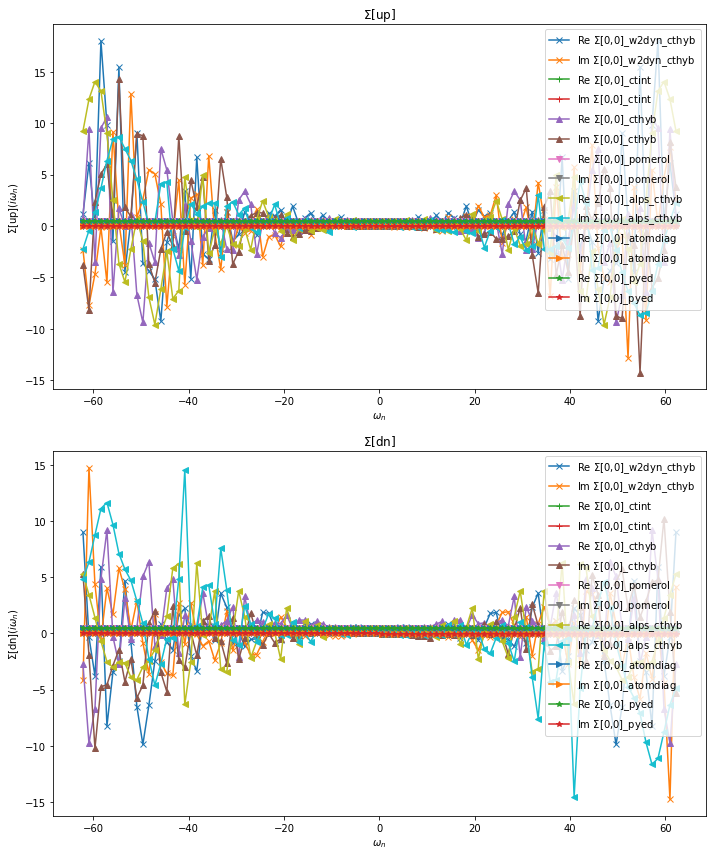

In [5]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
marker_lst = ['-x', '-+', '-^', '-v', '-<', '->', '-*', '-p']
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            marker = marker_lst[solver_lst.index(solver)]
            oplot(g[solver][block][0,0], marker, name = name + "[0,0]_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [6]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print("\t\t    Deviations for Block " + block)
    print("\t\t -----------------------------------")

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print(row_format.format("", *solver_lst))
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print(row_format.format(solver, *row))
        
    print("\n\n")

		    Deviations for Block up
		 -----------------------------------
                   w2dyn_cthyb          ctint          cthyb        pomerol     alps_cthyb       atomdiag           pyed
    w2dyn_cthyb       0.00E+00       7.87E-03       1.03E-02       7.87E-03       1.39E-02       7.87E-03       7.87E-03
          ctint       7.87E-03       0.00E+00       5.53E-03       1.20E-04       8.69E-03       1.20E-04       1.20E-04
          cthyb       1.03E-02       5.53E-03       0.00E+00       5.53E-03       9.05E-03       5.53E-03       5.53E-03
        pomerol       7.87E-03       1.20E-04       5.53E-03       0.00E+00       8.69E-03       2.25E-07       2.25E-07
     alps_cthyb       1.39E-02       8.69E-03       9.05E-03       8.69E-03       0.00E+00       8.69E-03       8.69E-03
       atomdiag       7.87E-03       1.20E-04       5.53E-03       2.25E-07       8.69E-03       0.00E+00       7.71E-15
           pyed       7.87E-03       1.20E-04       5.53E-03       2.25E-07       8.